<a href="https://colab.research.google.com/github/youssef227/diamond_price_prediction/blob/main/Image_prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception, VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Input
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
import zipfile
import seaborn as sns
from os import listdir, makedirs

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv( "/content/gdrive/MyDrive/Diamond/allImage.csv", index_col=0)
df

,Id,Type
0,1524552.jpg,cushion
1,1533986.jpg,cushion
2,1534911.jpg,cushion
3,1548301.jpg,cushion
4,1549891.jpg,cushion
...,...,...
1398,1800555.jpg,round
1399,1800567.jpg,round
1400,1800574.jpg,round
1401,1800575.jpg,round


There are 6 Type


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


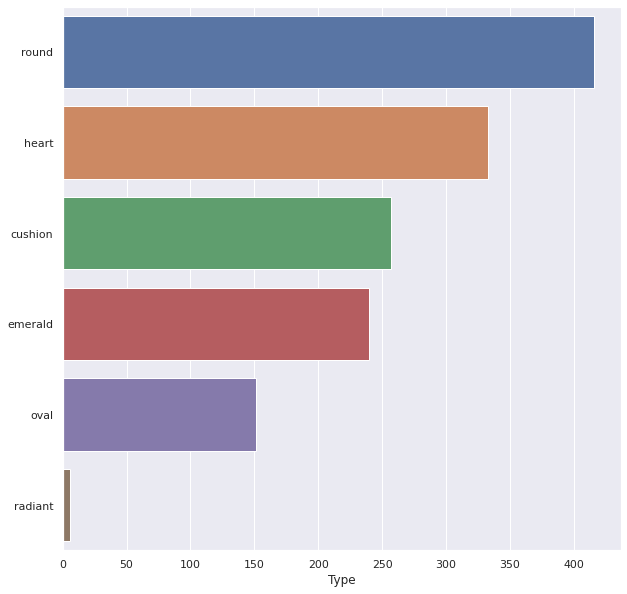

Number of Type:  6


In [5]:
# Build a dataframe with the number of instances in each class
Type_distrib = df['Type'].value_counts()
Type_count = len(set(df['Type']))
Type_distrib.columns = ['Type', 'number']
print(f"There are {Type_count} Type")
# Horizontal bar plot
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.set(font_scale=1)
ax = sns.barplot(Type_distrib,Type_distrib.index)
plt.show()
Type = df["Type"].unique()
print("Number of Type: ", len(Type))
Type2id = {name: i for i, name in enumerate(Type)}
id2Type = {i: name for i, name in enumerate(Type)}


In [6]:
print('***********************************')
res = df['Type'].value_counts()
print(res)
print('***********************************')

***********************************
round      416
heart      333
cushion    257
emerald    240
oval       151
radiant      6
Name: Type, dtype: int64
***********************************


In [7]:
# We droped radiant rows as it is very low in the data set and considered  nonuniformaly distributed
df.drop(df[(df['Type'] == "radiant" )].index, inplace=True)
df = df.reset_index()
df['Type'].value_counts()

round      416
heart      333
cushion    257
emerald    240
oval       151
Name: Type, dtype: int64

In [8]:
id_ = df.loc[0, 'Id']
id_

'1524552.jpg'

In [9]:
id_ = df.loc[0, 'Id']
Type = df.loc[0, 'Type']
file = id_
img = cv2.imread('/content/gdrive/MyDrive/Diamond/all Images/'+id_)
print('Shape:', img.shape)

Shape: (300, 300, 3)


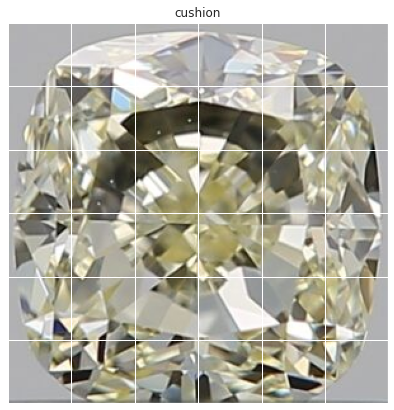

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(Type)
plt.show()

In [11]:
def plot_examples(Type = 'cushion'):
    """ Plot 5 images of a given category """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 20))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    temp = df[df['Type']==Type].copy()
    temp.index = range(len(temp.index))
    for i in range(5):
        id_ = df.loc[i, 'Id']
        Type = df.loc[i, 'Type']
        file = id_
        img = cv2.imread('/content/gdrive/MyDrive/Diamond/all Images/'+id_)
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(Type)
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()

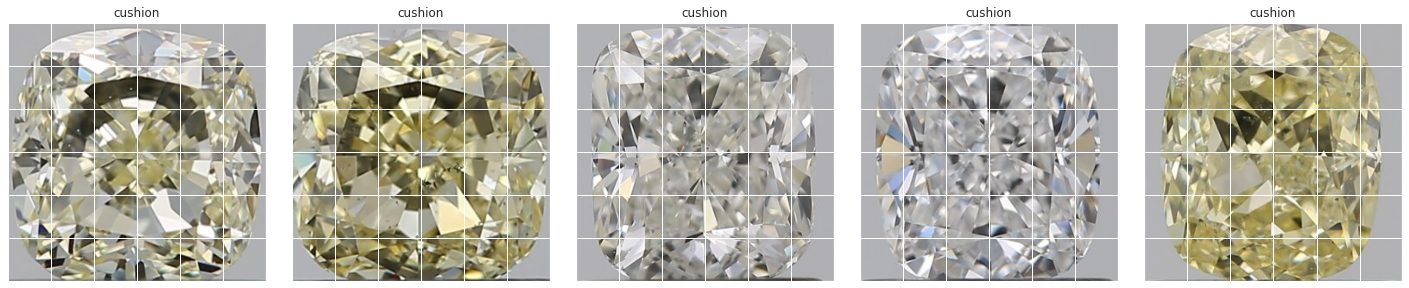

In [12]:
plot_examples()

**Image Preprocessing**

As we can see the images have different format: landscape or portrait. For the neural network we need a standard size. So we have to prepare the data.

In [13]:
def image_preprocessing(image, image_size):

    # Load Image
    readFlag=cv2.COLOR_BGR2GRAY
    image_gray = cv2.cvtColor(image, readFlag)
    
    # Crop Image
    mid_row = int(image_gray.shape[0]/2)
    mid_col = int(image_gray.shape[1]/2)
    if image_gray.shape[0]>image_gray.shape[1]:
        image_cropped = image_gray[mid_row-mid_col:mid_row+mid_col,
                                   0:image_gray.shape[1]]
    else:
        image_cropped = image_gray[0:image_gray.shape[0],
                                   mid_col-mid_row:mid_col+mid_row]
    
    # Rescale Image
    image_rescale = cv2.resize(image_cropped,
                               dsize=(image_size, image_size),
                               interpolation=cv2.INTER_AREA)
    return image_rescale

def plot_befor_after(image):

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    # Plot Original Image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('original shape: '+str(image.shape))
    # Image Preprocessing
    image_rescale = image_preprocessing(image, image_size)
    # Plot Prepared Image
    axs[1].imshow(image_rescale, cmap='gray')
    axs[1].set_title('rescaled shape: '+str(image_rescale.shape))
    for i in range(2):
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
    plt.show()

We set the image size:

In [14]:
image_size = 128

Example Landscape:

In [15]:
row = 0
id_ = df.loc[row, 'Id']
Type = df.loc[row, 'Type']
file = id_
image = cv2.imread('/content/gdrive/MyDrive/Diamond/all Images/'+id_)
print('Shape:', image.shape)

Shape: (300, 300, 3)


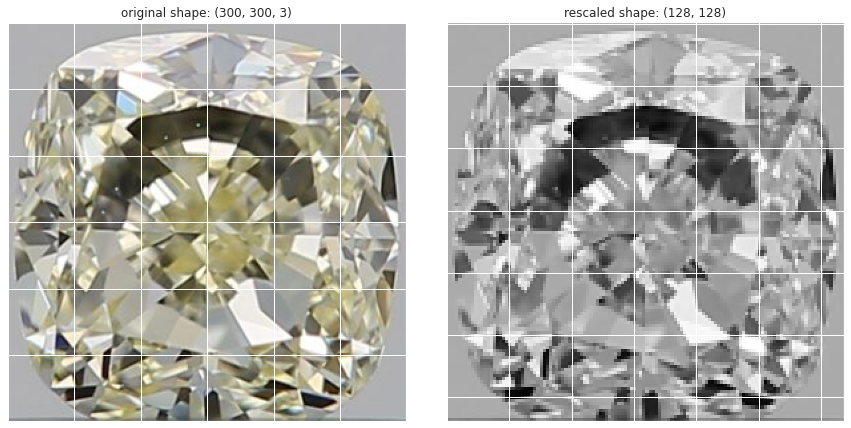

In [16]:
plot_befor_after(image)

In [17]:
row = 700
id_ = df.loc[row, 'Id']
Type = df.loc[row, 'Type']
file = id_
image = cv2.imread('/content/gdrive/MyDrive/Diamond/all Images/'+id_)
print('Shape:', image.shape)

Shape: (300, 300, 3)


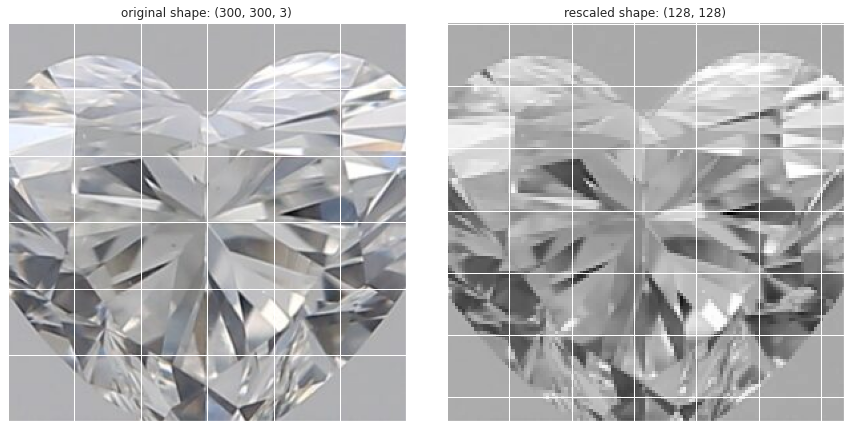

In [18]:
plot_befor_after(image)

Feature Extraction using ORB Detector

Shape: (300, 300, 3)


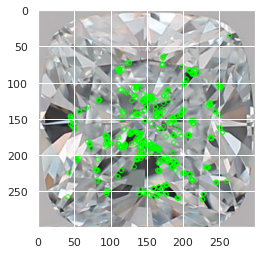

(494, 32)


In [19]:
row = 8
id_ = df.loc[row, 'Id']
Type = df.loc[row, 'Type']
file = id_
img = cv2.imread('/content/gdrive/MyDrive/Diamond/all Images/'+id_)
print('Shape:', img.shape)

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)

plt.imshow(img2)
plt.show()

print(des.shape)

image descriptors

In [20]:
print(des)

[[182  28 237 ... 125  52 242]
 [ 69 179  26 ...   3  43 145]
 [ 37  72 103 ... 187 112 136]
 ...
 [207 252 130 ...  84 171  94]
 [176  13  98 ... 104 118 174]
 [201 107 210 ... 241  35 137]]


In [21]:
data_df = pd.DataFrame(des)

In [22]:
data_df.dropna(axis=1,how='all')

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,182,28,237,188,95,241,93,250,23,94,...,102,191,211,99,219,187,55,125,52,242
1,69,179,26,170,218,133,58,216,58,89,...,154,81,156,133,47,236,152,3,43,145
2,37,72,103,200,84,151,226,112,197,128,...,84,236,115,8,133,0,119,187,112,136
3,210,90,239,188,6,74,254,103,184,134,...,146,107,177,35,255,144,69,112,244,91
4,146,214,7,168,87,211,40,111,12,73,...,19,213,144,96,154,202,28,12,181,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,11,236,174,220,93,149,248,102,133,132,...,146,173,107,127,221,57,6,174,56,202
490,252,63,254,36,109,46,87,80,225,170,...,152,40,211,249,65,50,106,247,90,19
491,207,252,130,18,209,220,118,230,187,83,...,154,227,59,86,30,107,138,84,171,94
492,176,13,98,87,4,234,228,103,113,130,...,165,207,33,62,210,0,101,104,118,174


In [23]:
X1 = data_df.iloc[:,:32]

In [24]:
y1 = data_df.iloc[:,32:]

In [25]:
X2 = des.reshape(-1,1)
X2

array([[182],
       [ 28],
       [237],
       ...,
       [241],
       [ 35],
       [137]], dtype=uint8)

In [26]:
y2 = des.reshape(-1,1)
y2

array([[182],
       [ 28],
       [237],
       ...,
       [241],
       [ 35],
       [137]], dtype=uint8)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.25, random_state = 0)

In [28]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()
scaler = StandardScaler()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
from sklearn.metrics import classification_report
matrix = classification_report(y_test,y_pred,labels=np.unique(y_pred))
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           2       0.00      0.00      0.00        16
          10       0.07      1.00      0.13        16
          16       0.00      0.00      0.00        13
          42       0.04      1.00      0.07        11
          50       0.12      1.00      0.21        25
          80       0.00      0.00      0.00        20
          95       0.00      0.00      0.00        16
         122       0.00      0.00      0.00        15
         138       0.00      0.00      0.00        21
         172       0.00      0.00      0.00        18
         184       0.00      0.00      0.00        21
         238       0.01      1.00      0.02        20

   micro avg       0.02      0.34      0.03       212
   macro avg       0.02      0.33      0.04       212
weighted avg       0.02      0.34      0.04       212



Read All Images

In [31]:
image_size = 128

In [32]:
df.iloc[0]
len(df)

1397

In [33]:
def prepare_data(path, data, image_size):
    """ Read all images into a numpy array """
    
    X = np.empty((len(data), image_size, image_size), dtype=np.uint8)
    for row in data.index:
        id_ = df.loc[row, 'Id']
        file = id_
        image = cv2.imread(path+file)
        image_rescaled = image_preprocessing(image, image_size)
        X[row, :, :] = image_rescaled
    X = X.astype('float32')/255
    return X

In [34]:
X_train = prepare_data('/content/gdrive/MyDrive/Diamond/all Images/', df, image_size)

In [35]:
y_train = df['Type']
# y_train = pd.get_dummies(y_train)
K= y_train
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
test=le.fit_transform(y_train)
y=pd.DataFrame(test)
y

,0
0,0
1,0
2,0
3,0
4,0
...,...
1392,4
1393,4
1394,4
1395,4


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.2, random_state=0)
print('Shape train data:', X_train.shape)
print('Shape val data:', X_test.shape)

Shape train data: (1117, 128, 128)
Shape val data: (280, 128, 128)


In [37]:
X_train = X_train.reshape(-1,image_size,image_size,1)
X_test = X_test.reshape(-1,image_size,image_size,1)

In [38]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(120, activation = 'softmax'))

In [39]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (image_size, image_size, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.15))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.15))


model.add(Flatten())

model.add(Dense(120, activation = "softmax"))

In [40]:
model.compile(optimizer = 'adam', loss= tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      832       
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [42]:
epochs = 50
batch_size = 120

In [43]:
#history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              #epochs = epochs, validation_data = (X_val,y_val), steps_per_epoch=X_train.shape[0] / batch_size)

history = model.fit(X_train, y_train, epochs=epochs,batch_size=batch_size,validation_data=(X_test, y_test))

Epoch 1/50
10/10 [==============================] - 164s 16s/step - loss: 2.3563 - accuracy: 0.2175 - val_loss: 1.6167 - val_accuracy: 0.2714
Epoch 2/50
10/10 [==============================] - 174s 17s/step - loss: 1.5784 - accuracy: 0.3044 - val_loss: 1.5391 - val_accuracy: 0.2321
Epoch 3/50
10/10 [==============================] - 160s 16s/step - loss: 1.5486 - accuracy: 0.2462 - val_loss: 1.5358 - val_accuracy: 0.2714
Epoch 4/50
10/10 [==============================] - 159s 16s/step - loss: 1.4670 - accuracy: 0.3375 - val_loss: 1.4259 - val_accuracy: 0.4464
Epoch 5/50
10/10 [==============================] - 152s 15s/step - loss: 1.1895 - accuracy: 0.5542 - val_loss: 1.2404 - val_accuracy: 0.4643
Epoch 6/50
10/10 [==============================] - 153s 15s/step - loss: 1.0805 - accuracy: 0.6634 - val_loss: 0.5990 - val_accuracy: 0.8571
Epoch 7/50
10/10 [==============================] - 153s 15s/step - loss: 0.3572 - accuracy: 0.8944 - val_loss: 0.2812 - val_accuracy: 0.8821
Epoch 

In [48]:
Y_pred = model.predict(X_train)
Y_pred

35/35 [==============================] - 31s 883ms/step


array([[1.0357643e-10, 2.6660218e-14, 9.9999994e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9629031e-12, 5.5655364e-10, 1.4402595e-13, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.7100830e-17, 9.9999994e-01, 3.8621153e-23, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.4093480e-17, 7.2006551e-20, 8.8463765e-15, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.8993127e-12, 2.3515564e-12, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.7455791e-16, 3.3518231e-20, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)